![](../storage/banners/14_iss.png)

### <span style="color:#0ab49a">Определение</span> <span style="color:#A254FC">движения</span> 

In [33]:
import os
import cv2
import gradio as gr
import numpy as np
from art import tprint
import matplotlib.pyplot as plt

path = "../storage/files/"
filename = "iss_1.MP4"
filename_cropped = "iss_1_crop.mp4"
filename_cutted = "iss_1_cut.mp4"
filename_speed = "iss_1_speed.mp4"

#### <span style="color:#5b77a9">Обрезка видео</span> 

In [ ]:
x = 900
y = 0
out_w = 300
out_h = 450
command = f'ffmpeg -i {path+filename} -vf "crop={out_w}:{out_h}:{x}:{y}" {path+filename_cropped}'
os.system(command)

In [ ]:
command = f'ffmpeg -ss 00:01:05.0 -i {path+filename_cropped} -c copy -t 00:04:45.0 {path+filename_cutted}'
os.system(command)

In [ ]:
command = f'ffmpeg -i {path+filename_cutted} -an -vf setpts=0.05*PTS {path+filename_speed}'
os.system(command)

#### <span style="color:#5b77a9">Обработка видео: контуры</span> 

In [ ]:
import time
import numpy as np

vidpath = path + filename_cutted
cap = cv2.VideoCapture(vidpath)

# Initialize Variables
_, frame = cap.read()
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (25, 25), 0)
previous_frame = gray

# Motion Detection Loop
counter = 0
boxes = [[0, 0, 0, 0, 0]]
while True:
    counter += 1
    flag, frame = cap.read()
    if not flag:
        break

    # Резче перенос
    if (counter - 1) % 250 == 0:

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (25, 25), 0)
        
        # Разница между кадрами
        frame_difference = cv2.absdiff(previous_frame, gray)
        
        # Пороговое значение
        _, threshold = cv2.threshold(frame_difference, 25, 255, cv2.THRESH_BINARY)
        
        # Нахождение контуров
        contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Draw Rectangles Around Moving Objects
        for contour in contours:
            if cv2.contourArea(contour) < 50 or cv2.contourArea(contour) > 1000:
                continue
            (x, y, w, h) = cv2.boundingRect(contour)
            boxes += [[counter, x, y, w, h]]
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        # Display Frames
        if (counter - 1) % 1000 == 0:
            f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
            ax1.imshow(frame_difference, 'gray')
            ax1.set_title('Разница')
            ax2.imshow(threshold, 'gray')
            ax2.set_title('Пороговое')
            ax3.imshow(frame)
            ax3.set_title('Контуры')
            plt.show()
        
        # Update Previous Frame
        previous_frame = gray
        
        # Exit on 'q' Pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break


Всего контуров: 94


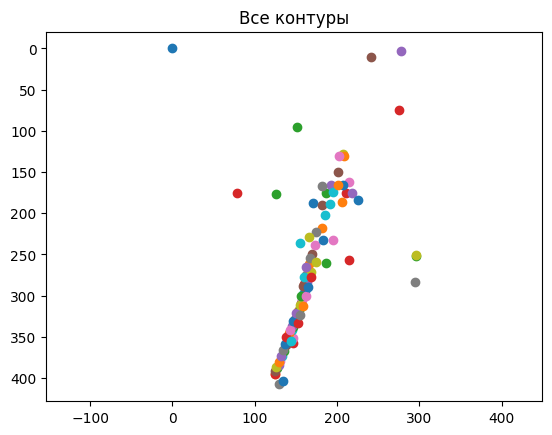

In [152]:
print(f"Всего контуров: {len(boxes)}")

for box in boxes:
    plt.scatter(box[1] + box[3]/2, box[2] + box[4]/2)
plt.gca().invert_yaxis()
plt.axis('equal')
plt.title('Все контуры')
plt.show()

Точек: 27


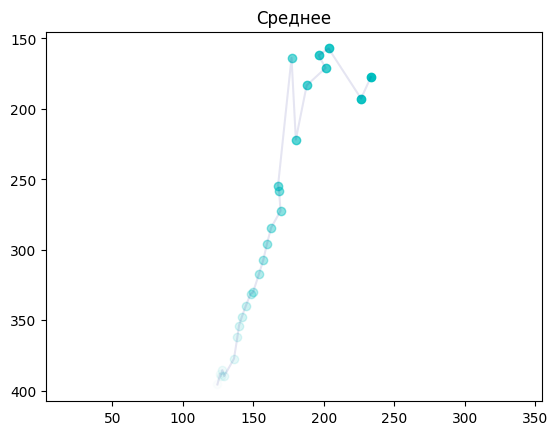

In [153]:
lst = set([i[0] for i in boxes])
lst.remove(0)
lst = list(lst)
lst.sort()

x_line, y_line = [], []
for t in lst:
    n = 0
    x = None
    y = None
    for box in boxes:
        if box[0] == t:
            x1 = box[1] + box[3]/2
            y1 = box[2] + box[4]/2
            x = x1 if x is None else x + x1
            y = y1 if y is None else y + y1
            n += 1
    plt.scatter(x/n, y/n, label=f"кадр {t}", c='c', alpha=(t/max(lst))**2)
    x_line += [x/n]
    y_line += [y/n]

print(f"Точек: {len(x_line)}")
plt.gca().invert_yaxis()
plt.plot(x_line, y_line, c='navy', alpha=0.1)
plt.axis('equal')
plt.title('Среднее')
# plt.legend()
plt.show()

#### <span style="color:#5b77a9">Обработка видео: YOLO</span>   

##### **Отрисовка**

In [38]:
def apply_yolo_object_detection(image_to_process):
    """
    Recognition and determination of the coordinates of objects on the image
    :param image_to_process: original image
    :return: image with marked objects and captions to them
    """

    height, width, _ = image_to_process.shape
    blob = cv2.dnn.blobFromImage(image_to_process, 1 / 255, (608, 608),
                                 (0, 0, 0), swapRB=True, crop=False)
    net.setInput(blob)
    outs = net.forward(out_layers)
    class_indexes, class_scores, boxes = ([] for i in range(3))
    objects_count = 0

    # Starting a search for objects in an image
    for out in outs:
        for obj in out:
            scores = obj[5:]
            class_index = np.argmax(scores)
            class_score = scores[class_index]
            if class_score > 0:
                center_x = int(obj[0] * width)
                center_y = int(obj[1] * height)
                obj_width = int(obj[2] * width)
                obj_height = int(obj[3] * height)
                box = [center_x - obj_width // 2, center_y - obj_height // 2,
                       obj_width, obj_height]
                boxes.append(box)
                class_indexes.append(class_index)
                class_scores.append(float(class_score))

    # Selection
    chosen_boxes = cv2.dnn.NMSBoxes(boxes, class_scores, 0.0, 0.4)
    for box_index in chosen_boxes:
        box_index = box_index
        box = boxes[box_index]
        class_index = class_indexes[box_index]

        # For debugging, we draw objects included in the desired classes
        if classes[class_index] in classes_to_look_for:
            objects_count += 1
            image_to_process = draw_object_bounding_box(image_to_process,
                                                        class_index, box)

    final_image = draw_object_count(image_to_process, objects_count)
    return final_image

# функцию, которая обведет найденные на изображении объекты с помощью координат границ, полученных из функции apply_yolo_object_detection
def draw_object_bounding_box(image_to_process, index, box):
    """
    Drawing object borders with captions
    :param image_to_process: original image
    :param index: index of object class defined with YOLO
    :param box: coordinates of the area around the object
    :return: image with marked objects
    """

    x, y, w, h = box
    start = (x, y)
    end = (x + w, y + h)
    color = (0, 255, 0)
    width = 2
    final_image = cv2.rectangle(image_to_process, start, end, color, width)

    start = (x, y - 10)
    font_size = 1
    font = cv2.FONT_HERSHEY_SIMPLEX
    width = 2
    text = classes[index]
    final_image = cv2.putText(final_image, text, start, font,
                              font_size, color, width, cv2.LINE_AA)

    return final_image

# вывод количества объектов
def draw_object_count(image_to_process, objects_count):
    """
    Signature of the number of found objects in the image
    :param image_to_process: original image
    :param objects_count: the number of objects of the desired class
    :return: image with labeled number of found objects
    """

    start = (10, 50)
    font_size = 0.5
    font = cv2.FONT_HERSHEY_SIMPLEX
    width = 1
    text = "Objects found: " + str(objects_count)

    # Text output with a stroke
    # (so that it can be seen in different lighting conditions of the picture)
    white_color = (255, 255, 255)
    black_outline_color = (0, 0, 0)
    final_image = cv2.putText(image_to_process, text, start, font, font_size,
                              black_outline_color, width * 3, cv2.LINE_AA)
    final_image = cv2.putText(final_image, text, start, font, font_size,
                              white_color, width, cv2.LINE_AA)

    return final_image

# функцию, которая будет обрабатывать видео по кадрам и выводить результат обработки на экран
def start_video_object_detection(video: str):
    """
    Real-time video capture and analysis
    """
    # Capturing a picture from a video
    video_camera_capture = cv2.VideoCapture(video)

    counter = 0
    while video_camera_capture.isOpened():
        counter += 1
        ret, frame = video_camera_capture.read()
        if not ret:
            break
        
        # Application of object recognition methods on a video frame from YOLO
        frame = apply_yolo_object_detection(frame)
        
        # Displaying the processed image on the screen with a reduced window size
        # cv2.imshow("Video Capture", frame)
        # cv2.waitKey(1)
        if (counter - 1) % 20 == 0:
            plt.imshow(frame)
            plt.show()
    
    video_camera_capture.release()
    # cv2.destroyAllWindows()

##### **Main**

In [ ]:
# Loading YOLO scales from files and setting up the network
net = cv2.dnn.readNetFromDarknet("Resources/yolov4-tiny.cfg",
                                 "Resources/yolov4-tiny.weights")
layer_names = net.getLayerNames()
out_layers_indexes = net.getUnconnectedOutLayers()
out_layers = [layer_names[index - 1] for index in out_layers_indexes]

# Loading from a file of object classes that YOLO can detect
with open("Resources/coco.names.txt") as file:
    classes = file.read().split("\n")

# Determining classes that will be prioritized for search in an image
# The names are in the file coco.names.txt

vidpath = path + filename_speed
classes_to_look_for = ['']

start_video_object_detection(vidpath)